# Notebook shows how to run CartoonX 

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import models
import numpy as np

import random
import os
import time

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

from imagenet_utils.imagenet_labels import imagenet_labels_dict
from cartoonx import CartoonX

plt.rcParams["font.family"] = "Times New Roman"

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

/home/groups/ai/kolek/miniconda3/envs/scat/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Model 
We first compute explanation masks for the [MobilenetV3](https://arxiv.org/pdf/1905.02244.pdf) model on for an image of a frog for [CartoonX](https://www.ecva.net/papers/eccv_2022/papers_ECCV/papers/136720439.pdf) (ours), [Smoothmask](https://www.robots.ox.ac.uk/~vedaldi/assets/pubs/fong19understanding.pdf), and [GradCAM](https://arxiv.org/pdf/1610.02391.pdf).

In [5]:
# Get device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Define input normalization layer for imagenet images
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean, device=device, requires_grad=False)
        self.std = torch.tensor(std, device=device, requires_grad=False)

    def forward(self, x):
        x = x - self.mean.reshape(self.mean.size(0),1,1)
        x = x / self.std.reshape(self.std.size(0),1,1)
        return x

# Get model
network = models.mobilenet_v3_small(pretrained=True).eval().to(device)
# Add input normalization layer
model = nn.Sequential(Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), network)

/home/groups/ai/kolek/miniconda3/envs/scat/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Load Image
We will start explaining the classification decision of a [Tree Frog](https://en.wikipedia.org/wiki/Tree_frog) for the image below.

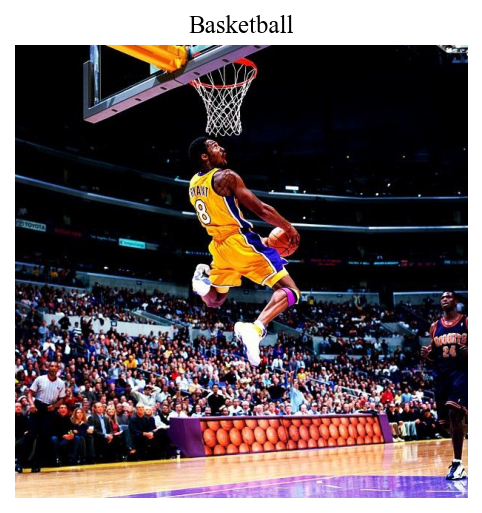

In [6]:
convert_to_tensor = transforms.Compose(
    [transforms.ToTensor(), transforms.Resize(size=(256,256))]
)
    

img = Image.open(os.path.join('imgs', 'kobe.jpg')).convert('RGB')
# Convert image to tensor
x = convert_to_tensor(img).unsqueeze(0).to(device)
# Get prediction for x
preds = nn.Softmax(dim=-1)(model(x)).max(1)[1].detach()

# Plot the image
plt.subplots(dpi=150)
plt.imshow(img)
plt.axis('off')
plt.title(imagenet_labels_dict[preds[0].item()].split(',')[0].capitalize())


# Show the plot
plt.show()


### Mask Explanations
A mask explanation optimizes an explanation mask tensor with values between zero and one on an input representation. The objective is to delete as much as possible while retaining the model output. 

### CartoonX
[CartoonX](https://www.ecva.net/papers/eccv_2022/papers_ECCV/papers/136720439.pdf) optimizes the explanation mask in the wavelet representation to leverage the fact that sparsity in wavelet space induces piece-wise smoothness in pixel space. Thereby CartoonX can extract the classifier-relevant pice-wise smooth part of an image.

<u>Hyperparameters:</u> 
- `l1lambda` = multiplier for l1 norm of wavelet mask
- `lr` = learning rate for optimization of wavelet mask
- `obfuscation` = noise perturbation distribution for mask ['uniform', 'gaussian']
- `optim_steps` = number of steps that optimize the mask
- `noise_bs` = batch size for noise perturbations
- `mask_init` = initial mask (works best with all ones as initial mask)

Iter 299/300
Time: 4.94


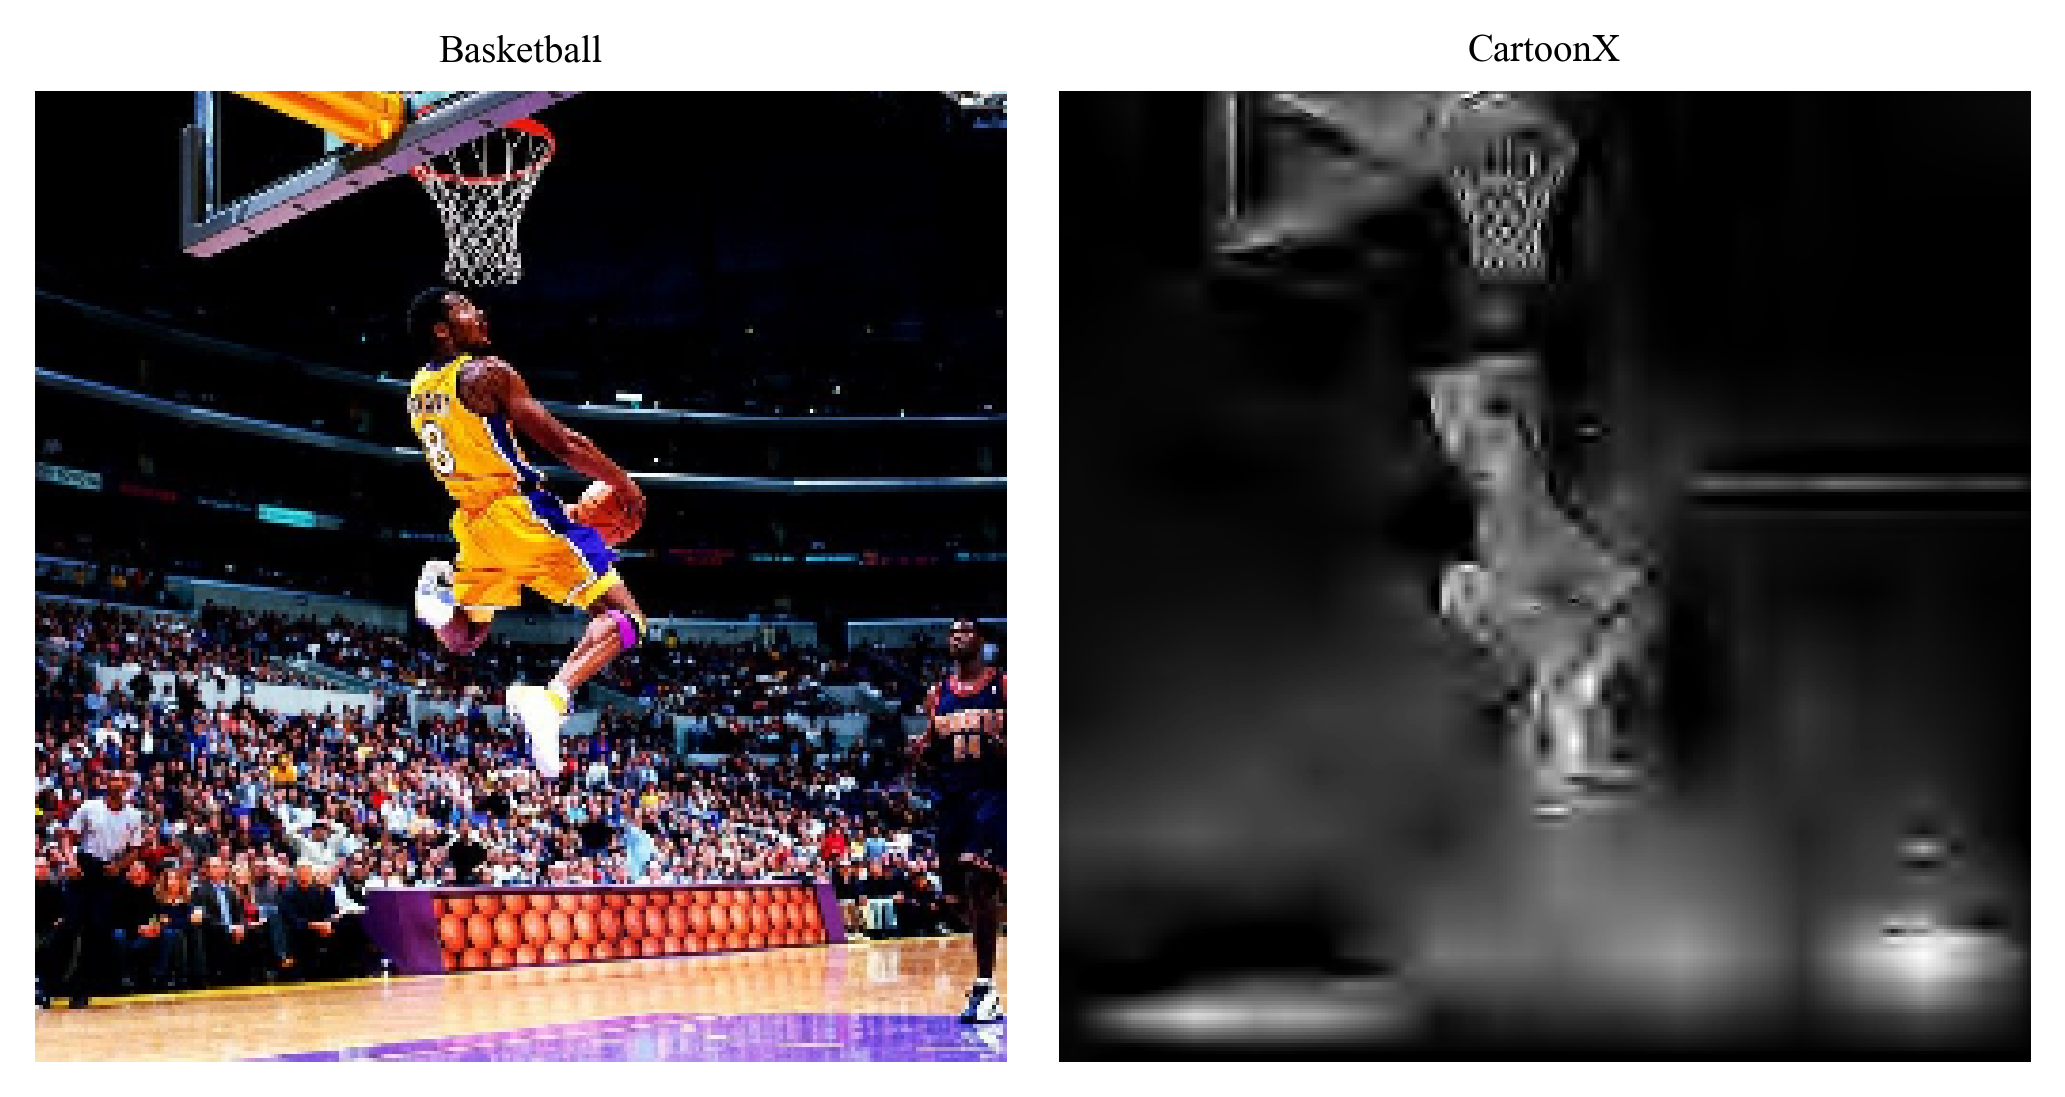

In [17]:
# Hparams WaveletX with spatial reg
CARTOONX_HPARAMS = {
    "l1lambda": 285., "lr": 1e-1, 'obfuscation': 'gaussian',
    "maximize_label": True, "optim_steps": 300,  
    "noise_bs": 16, 'mask_init': 'ones'
} 

# ============================== Compute CartoonX ===============================
t = time.time()
cartoonx_method = CartoonX(model=model, device=device, **CARTOONX_HPARAMS)
cartoonx, history_cartoonx = cartoonx_method(x, preds)
cartoonx = cartoonx/cartoonx.max()
print(f'\nTime: {time.time()-t:.2f}')

# ============================== Plot Explanation ==============================
# ============================== Plot Explanation ==============================
fig, axs = plt.subplots(1,2, dpi=350)
s = 8 # fontsize
# Input Image
axs[0].imshow(x.squeeze(0).permute(1,2,0).cpu())
axs[0].set_title(imagenet_labels_dict[preds[0].item()].split(',')[0].capitalize(), fontsize=s)
axs[0].axis('off')


# CartoonX Visualization
axs[1].imshow(cartoonx.squeeze(0).sum(dim=0).cpu()/3, cmap='gray')
axs[1].axis('off')
axs[1].set_title('CartoonX', fontsize=s
)


plt.tight_layout()
plt.show()
